In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline 
import warnings
warnings.filterwarnings('ignore')

In [17]:
data = pd.read_csv('HR_DS.csv')

In [18]:
# Encode categorical variables
le = LabelEncoder()
categorical_cols = data.select_dtypes(include=['object']).columns
data[categorical_cols] = data[categorical_cols].apply(lambda col: le.fit_transform(col))
data['Attrition'] = le.fit_transform(data['Attrition'])

In [19]:
# Split the data into training and testing sets
X = data.drop('Attrition', axis=1)
y = data['Attrition']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
# Feature selection using Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
model_selector = SelectFromModel(rf, prefit=True)
X_train_selected = model_selector.transform(X_train)
X_test_selected = model_selector.transform(X_test)

In [21]:
pipe = imbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [26]:
search_space = [{'classifier': [RandomForestClassifier()],
                 'classifier__n_estimators': [10, 100, 1000],
                 'classifier__max_features': [1, 2, 3]},
                {'classifier': [DecisionTreeClassifier()],
                 'classifier__criterion': ['gini', 'entropy'],
                 'classifier__max_depth': [None, 10, 20, 30, 40, 50]}
]

In [27]:
clf = GridSearchCV(pipe, search_space, cv=5, verbose=0)

In [28]:
best_model = clf.fit(X_train_selected, y_train)

In [29]:
separator = "\n" + "="*40 + "\n"
print(f"Best estimator:{separator}{best_model.best_estimator_}\n")
print(f"Best parameters:{separator}{best_model.best_params_}\n")

Best estimator:
Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('classifier',
                 RandomForestClassifier(max_features=1, n_estimators=1000))])

Best parameters:
{'classifier': RandomForestClassifier(), 'classifier__max_features': 1, 'classifier__n_estimators': 1000}



In [30]:
y_pred = best_model.predict(X_test_selected)

In [31]:
# Evaluation
print(f"Accuracy Score:{separator}{accuracy_score(y_test, y_pred)}\n")
print(f"Confusion Matrix:{separator}{confusion_matrix(y_test, y_pred)}\n")
print(f"Classification Report:{separator}{classification_report(y_test, y_pred)}\n")

Accuracy Score:
0.8231292517006803

Confusion Matrix:
[[227  28]
 [ 24  15]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.89      0.90       255
           1       0.35      0.38      0.37        39

    accuracy                           0.82       294
   macro avg       0.63      0.64      0.63       294
weighted avg       0.83      0.82      0.83       294




In [ ]:
from sklearn.metrics import precision_recall_curve, auc

In [ ]:
# Assuming y_prob is the probability of the positive class
y_prob = best_model.predict_proba(X_test_selected)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_prob)
auc_score = auc(recall, precision)
print(f'Precision-Recall AUC: {auc_score}')

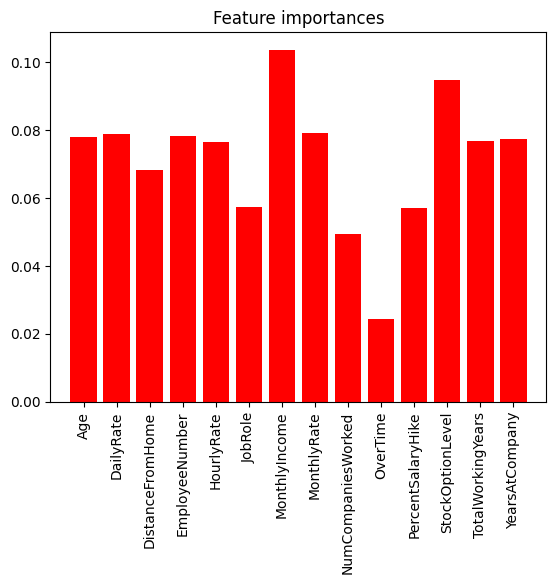

In [32]:
# Visualize feature importance (if RandomForest is the best model)
if isinstance(best_model.best_estimator_.named_steps['classifier'], RandomForestClassifier):
    importances = best_model.best_estimator_.named_steps['classifier'].feature_importances_
    feature_names = X_train.columns[model_selector.get_support()]
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X_train_selected.shape[1]), importances,
            color="r", align="center")
    plt.xticks(range(X_train_selected.shape[1]), feature_names, rotation='vertical')
    plt.xlim([-1, X_train_selected.shape[1]])
    plt.show()

In [ ]:
search_space = [{'classifier': [LogisticRegression()],
                 'classifier__penalty': ['l1', 'l2'],
                 'classifier__C': [0.1, 1.0, 10.0]},
                {'classifier': [RandomForestClassifier()],
                 'classifier__n_estimators': [10, 100, 1000],
                 'classifier__max_features': [1, 2, 3]},
                {'classifier': [SVC()],
                 'classifier__kernel': ['linear', 'rbf'],
                 'classifier__C': [0.1, 1.0, 10.0]},
                {'classifier': [DecisionTreeClassifier()],
                 'classifier__criterion': ['gini', 'entropy'],
                 'classifier__max_depth': [None, 10, 20, 30, 40, 50]},
                {'classifier': [MLPClassifier()],
                 'classifier__hidden_layer_sizes': [(50,), (100,), (50, 50)],
                 'classifier__activation': ['relu', 'tanh', 'logistic'],
                 'classifier__learning_rate': ['constant', 'adaptive']}]

In [33]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [34]:
param_dist = {
    'classifier__n_estimators': randint(100, 2000),
    'classifier__max_features': ['auto', 'sqrt', 'log2'],
    'classifier__max_depth': randint(1, 20),
    'classifier__min_samples_split': randint(2, 20),
    'classifier__min_samples_leaf': randint(1, 20),
    'classifier__bootstrap': [True, False]
}

In [35]:
# Create the random search object
random_search = RandomizedSearchCV(pipe, param_distributions=param_dist, n_iter=100, cv=5, verbose=1, n_jobs=-1, random_state=42)

# Fit to the data
random_search.fit(X_train_selected, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                             ('classifier',
                                              RandomForestClassifier(random_state=42))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'classifier__bootstrap': [True, False],
                                        'classifier__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x12ad5ea90>,
                                        'classifier__max_features': ['auto',
                                                                     'sqrt',
                                                                     'log2'],
                                        'classifier__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x12aee9490>,
                                        'classifier__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x12ab2be90>,
                                        'classifier__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x12aec8210>},
                   random_state=42, verbose=1)